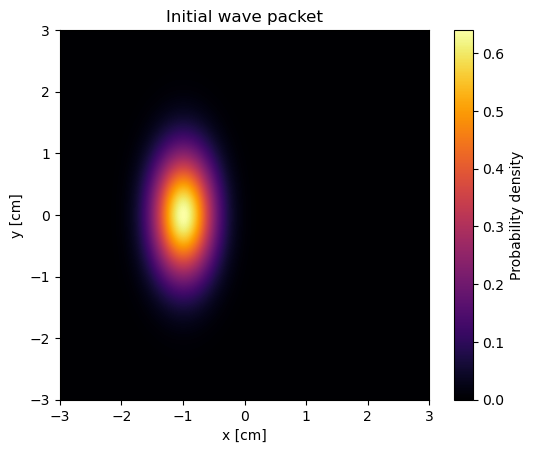

In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import numba
from numba import jit
from IPython.display import HTML
from matplotlib.ticker import MultipleLocator
from scipy.signal import find_peaks

# physical quantities
e_charge = -1.602176634e-19
hbar = 1.05457182e-30
e_mass = 9.1093837e-31

# lattice size in space and time
L = 6 # in centimeter
T = 0.1 # in seconds
x_0 = 3 # in centimeter
y_0 = 3 # in centimeter

# lattice quantities
Nx = 400  # Number of x-axis points
Ny = 400 # Number of y-axis points
Nt = 500000 # Number of temporal-axis points

# lattice spacing
a_t = T / Nt
a_x = L / Nx
a_y = L / Ny

# lattice initialization
vec_x = np.linspace(-x_0, L - x_0, Nx)
vec_y = np.linspace(-y_0, L - y_0, Ny)

x, y = np.meshgrid(vec_x, vec_y)

# Gaussian wave packet initialization
n_kx = 20 # x momentum
n_ky = 0 # y momentum

# Initial wave packet on lattice
psi_0 = np.zeros([2, Ny, Nx],dtype=np.complex64) # first row of two integer is used for time evolution
psi_0[0] = np.exp(-((y) ** 2 / (2 * 1 ** 2) + ( x + 1) ** 2 / (2 * 0.5 ** 2)) + 2 * math.pi / L * 1j * n_kx * x)

# Normalization to 1
normal = np.sum(np.absolute(psi_0[0]) ** 2) * a_x * a_y 
psi_0[0] = psi_0[0] / np.sqrt(normal)


# psi_0 plot
plt.imshow((np.absolute(psi_0[0]) ** 2), cmap='inferno', origin='lower', extent=[- x_0, L - x_0,- y_0, L - y_0])
plt.colorbar(label=f'Probability density')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('Initial wave packet')

plt.show()

Slits lenght: 0.3
Slits distance: 0.9
Wall thickness: 0.3
Numerical coefficients: 0.0010290456568794366 -5.8627333702059335e-06 1.6700737396996382e-08


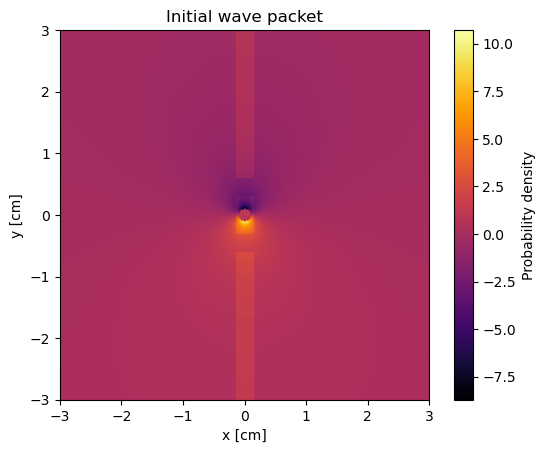

In [36]:
# Potential function 
V = np.zeros([Ny,Nx])

# Positioning of the wall on x axis
N_min_wall = 190#95#190
N_max_wall = 210#105#210
# to cm
x_min_wall = N_min_wall * a_x + x_0
x_max_wall = N_max_wall * a_x + x_0
wall_thick = round(np.absolute(x_max_wall-x_min_wall),2)

# Positioning of slits (1 and 2) width on y axis
N_left_s1 = 160#120#80#160
N_right_s1 = 180#135#90#180
N_left_s2 = 220#165#110#220
N_right_s2 = 240#180#120#240

left_s1 = N_left_s1 * a_y - y_0
right_s1 = N_right_s1 * a_y - y_0
left_s2 = N_left_s2 * a_y - y_0
right_s2 = N_right_s2 * a_y - y_0


# Slits width (l) and distance between their center (d)
l = round(np.absolute(left_s1-right_s1),2)
d = round(np.absolute((left_s1 + right_s1)/2 - (left_s2 + right_s2)/2 ),2)

# Assigning a value to the potential where the wall is placed
for i in range(N_min_wall, N_max_wall):
    for j in range(0, N_left_s1):
        V[j, i] = 1
    for j in range(N_right_s1, N_left_s2):
        V[j, i] = 1
    for j in range(N_right_s2, Ny):
        V[j, i] = 1

# Check slits and wall position
print("Slits lenght:" ,l)
print("Slits distance:" ,d)
print("Wall thickness:" ,wall_thick)

#-----------------------------------------------------

# Magnetic vctor potential

# Position of the singularity
N_centre_x = 200#150#100#200
centre_x = N_centre_x * a_x - x_0

# Vector potential function
def vector_pot(x, y):
    r_squared = (x-centre_x)**2 + (y)**2
    mask = (r_squared < 0.01)
    
    u = np.where(mask, 0, -(y) / r_squared)
    v = np.where(mask, 0, (x-centre_x) / r_squared)
    return u, v

# Vector potential component on lattice
Ax, Ay = vector_pot(x, y)

# Physical quantites
B = 5e-8 # Magnetic field
R = 0.01 # Solenoid radius
phi = math.pi * R ** 2 * abs(B) # Magnetic flux

# Coefficient of the finite differtence formula (see .pdf)
gamma1 = hbar / e_mass
gamma2 = phi * e_charge / (2 * math.pi * e_mass)
gamma3 = (phi * e_charge) ** 2 / (8 * math.pi ** 2 * e_mass * hbar)

C1_x = gamma1 * a_t / a_x ** 2
C1_y = gamma1 * a_t / a_y ** 2
C2_x = gamma2 * a_t / a_x
C2_y = gamma2 * a_t / a_y 
C3 = gamma3 * a_t

# Check
print("Numerical coefficients:" ,C1_x,C2_x,C3)

# potential plot
plt.imshow(V+Ax, cmap='inferno', origin='lower', extent=[- x_0, L - x_0,- y_0, L - y_0])
plt.colorbar(label=f'Probability density')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('Initial wave packet')

plt.show()

In [17]:
# Finite difference formula
@numba.jit("c16[:,:,:](c16[:,:,:],float32,float32,float32,float32,float32)", nopython=True, nogil=True)
def compute_psi(psi,C1_x,C1_y,C2_x,C2_y,C3):
    for t in range(0, Nt-1):
        for i in range(0, Ny):
            ip=(Ny+i+1)%(Ny)
            im= (Ny+i-1)%(Ny)
            for k in range(0, Nx):
                kp=(Nx+k+1)%(Nx)
                km= (Nx+k-1)%(Nx)
                if V[i][k] == 0: # solution is computed outside the wall   
                    psi[1][i][k] = psi[0][i][k] * (1 - 1j * a_t * V[i][k] - 1j * C1_x - 1j * C1_y - 1j * C3 * (Ax[i][k] ** 2 + Ay[i][k] ** 2) ) \
                 + psi[0][ip][k] * (1j * C1_y / 2. + C2_y / 2. * Ay[i][k]) \
                 + psi[0][im][k] * (1j * C1_y / 2. - C2_y / 2. * Ay[i][k]) \
                 + psi[0][i][kp] * (1j * C1_x / 2. + C2_x / 2. * Ax[i][k]) \
                 + psi[0][i][km] * (1j * C1_x / 2. - C2_x / 2. * Ax[i][k])
                else: # we are inside the wall, solution is set to zero
                     psi[1][i][k] = 0
                        
        psi[0] = psi[1]

    return psi

In [18]:
# solution is computed with no magnetic field
solution = np.abs(compute_psi(psi_0.astype(complex),C1_x,C1_y,0,0,0)[1])**2

In [19]:
# solution is computed with magnetic field
solution_shift = np.abs(compute_psi(psi_0.astype(complex),C1_x,C1_y,C2_x,C2_y,C3)[1])**2

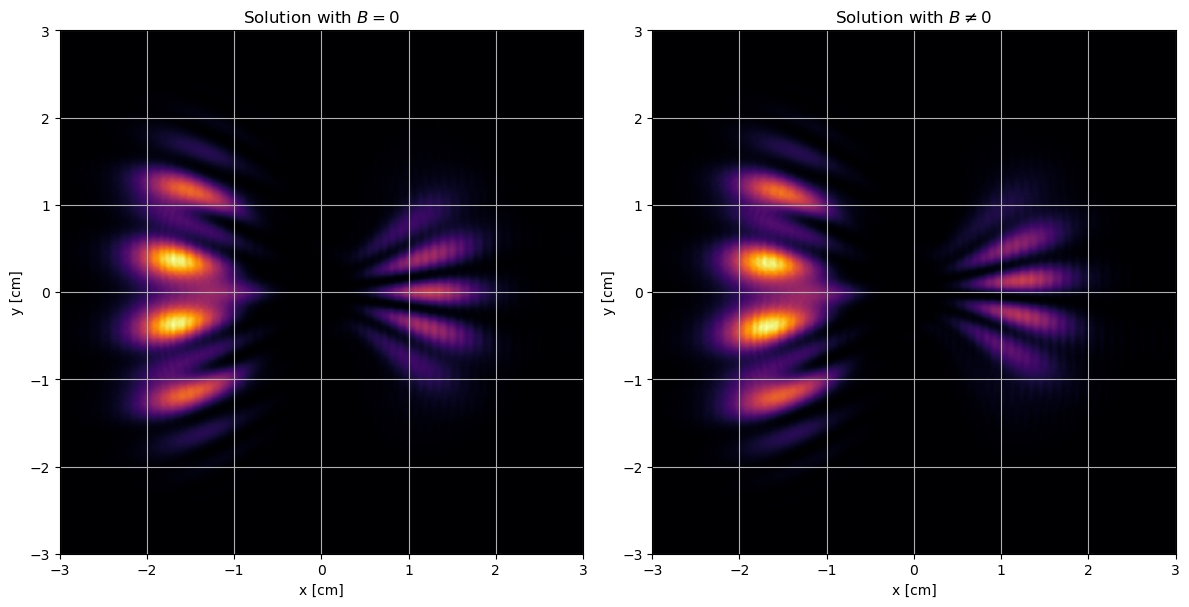

In [20]:
# Plot of the solutions
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

# first subplot
axs[0].imshow((solution), cmap='inferno', origin='lower', extent=[-3, 3, -3, 3])
axs[0].set_title(r'Solution with $B=0$')
axs[0].set_xlabel('x [cm]')
axs[0].set_ylabel('y [cm]')
axs[0].set_aspect('equal')
axs[0].grid(True)
axs[0].set_xlim([-3, 3])
axs[0].set_ylim([-3, 3])
axs[0].set_xticks([-3, -2, -1, 0, 1, 2, 3])

# Second subplot
axs[1].imshow((solution_shift), cmap='inferno', origin='lower', extent=[-3, 3, -3, 3])
axs[1].set_title(r'Solution with $B\neq0$')
axs[1].set_xlabel('x [cm]')
axs[1].set_ylabel('y [cm]')
axs[1].set_aspect('equal')
axs[1].grid(True)
axs[1].set_xlim([-3, 3])
axs[1].set_ylim([-3, 3])
axs[1].set_xticks([-3, -2, -1, 0, 1, 2, 3])

plt.tight_layout()
plt.show()

In [21]:
# print the solutions
with open("solutions/solution_B_0_400pt.txt", "w") as file:
    for riga in solution:
        file.write(f"[{', '.join(map(str, riga))}]\n")
        
with open("solutions/solution_B_05mu_400pt.txt", "w") as file:
    for riga in solution_shift:
        file.write(f"[{', '.join(map(str, riga))}]\n")

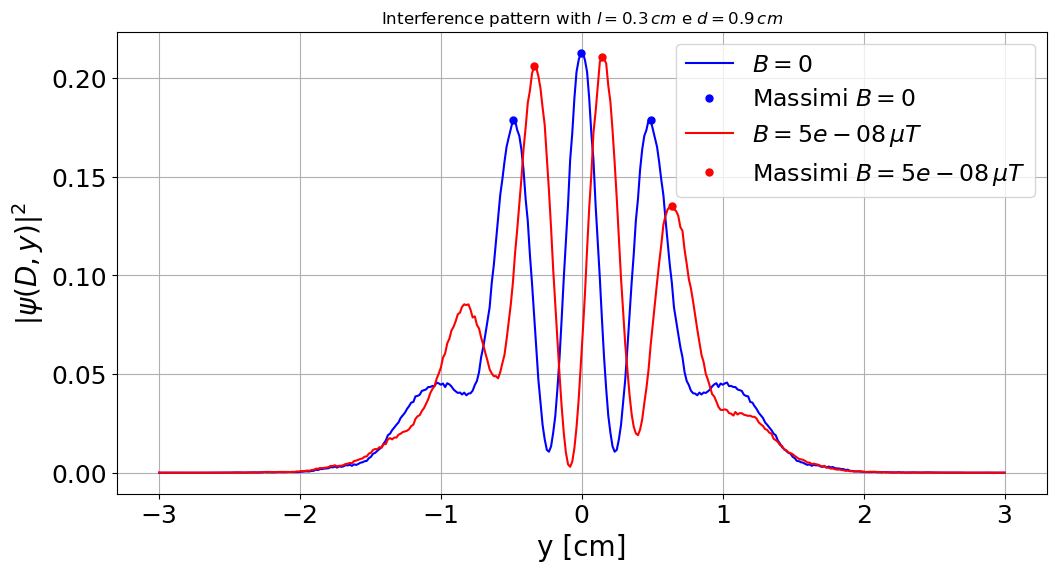

Expected shift: 0.186
Measured shift: 0.15
t value: 1.17


In [27]:
from scipy.signal import find_peaks
from scipy import stats

# 
data_0 = np.loadtxt("solutions/solution_B_0_400pt.txt", delimiter=',', dtype=str)
data_0 = np.char.strip(data_0, '[]')
data_0 = data_0.astype(float)
#
data_b = np.loadtxt("solutions/solution_B_05mu_400pt.txt", delimiter=',', dtype=str)
data_b = np.char.strip(data_b, '[]')
data_b = data_b.astype(float)

# revelation screen position on x axis
x_screen = 1.5
spot = int((x_screen + x_0) / a_x)
# Save the solution on the screen
slice_0 = data_0[:, spot]
slice_b = data_b[:, spot]

#-----------------------------------------------

# FIND PEAKS

# interval extremes in which peaks are to be searched
int_min = -0.6
int_max = 0.7
interval = np.where((vec_y >= int_min) & (vec_y <= int_max))[0] # interval in which peaks are to be searched

# Find peaks for still solution
slice_0_int = slice_0[interval] # restrict solution to chosen interval
peaks_0, _ = find_peaks(slice_0_int) # find peaks
periods_0 = np.diff(vec_y[interval][peaks_0]) # find period of the interference pattern
# compute mean and std dev of periods
mean_0 = round(np.mean(periods_0),4)

# Find peaks for solution with magnetic field
slice_b_int = slice_b[interval] # restrict solution to chosen interval
peaks_b, _ = find_peaks(slice_b_int) # find peaks
periods_b = np.diff(vec_y[interval][peaks_b]) # find period of the interference pattern
# compute mean and std dev of periods
mean_b = round(np.mean(periods_b),4)

std_dev = round(4*(a_y)/np.sqrt(4),4)

#-----------------------------------------------

# print peaks position along the reveal screen
with open('analysis/max_0.txt', 'w') as file:
    for value in vec_y[interval][peaks_0]:
        file.write(str(value) + '\n')

with open('analysis/max_b.txt', 'w') as file:
    for value in vec_y[interval][peaks_b]:
        file.write(str(value) + '\n')

# Plot interference pattern for still and magnetic solutions
plt.figure(figsize=(12, 6))

plt.plot(vec_y, slice_0, label='$B=0$', color='blue')
plt.plot(vec_y[interval][peaks_0], slice_0_int[peaks_0], 'bo', markersize=5, label='Massimi $B=0$')

plt.plot(vec_y, slice_b, label=f'$B={B}\,\mu T$', color='red')
plt.plot(vec_y[interval][peaks_b], slice_b_int[peaks_b], 'ro', markersize=5, label=f'Massimi $B={B}\,\mu T$')

plt.title(f'Interference pattern with $l={l}\,cm$ e $d={d}\,cm$',fontsize=12)
plt.xlabel('y [cm]',fontsize=20)
plt.ylabel(r"$\left|\psi(D,y)\right|^2$",fontsize=20)
plt.tick_params(axis='x', labelsize=18)  
plt.tick_params(axis='y', labelsize=18)
plt.legend(fontsize=17)
plt.grid(True)
plt.savefig("figures/peaks_05.pdf")
plt.show()

#comparison

delta_y = np.absolute(np.mean(vec_y[interval][peaks_0] - vec_y[interval][peaks_b]))
delta_y_exp = np.absolute((e_charge*mean_0*R**2*B)/(2*hbar))

print("Expected shift:", round(delta_y_exp,3))
print("Measured shift:", round(delta_y,3))
print("t value:", round(np.absolute(delta_y-delta_y_exp)/std_dev,2))